# Surface Reflection Correction

這個notebook會：
1. 載入完整fiber raw data
2. 執行surface reflection correction
3. 將修正後的資料以parquet格式儲存（壓縮、省空間）

In [1]:
GAUGE_LENGTH = 10
SAMPLES = 1000
MULT = 4.0838
DAS_CNST = 116/8192*10**(-9)*SAMPLES/GAUGE_LENGTH

In [16]:
%load_ext autoreload
%autoreload 2
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)
import pandas as pd
import numpy as np
from obspy import read
import tqdm
from scripts.surface_reflections_correction import correct_surface_reflection, load_das_profile, plot_up_down_original, plot_channel_traces
from scripts.picking_module import process_event
from scripts.raw_data_plot import plot_filled_timeseries

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


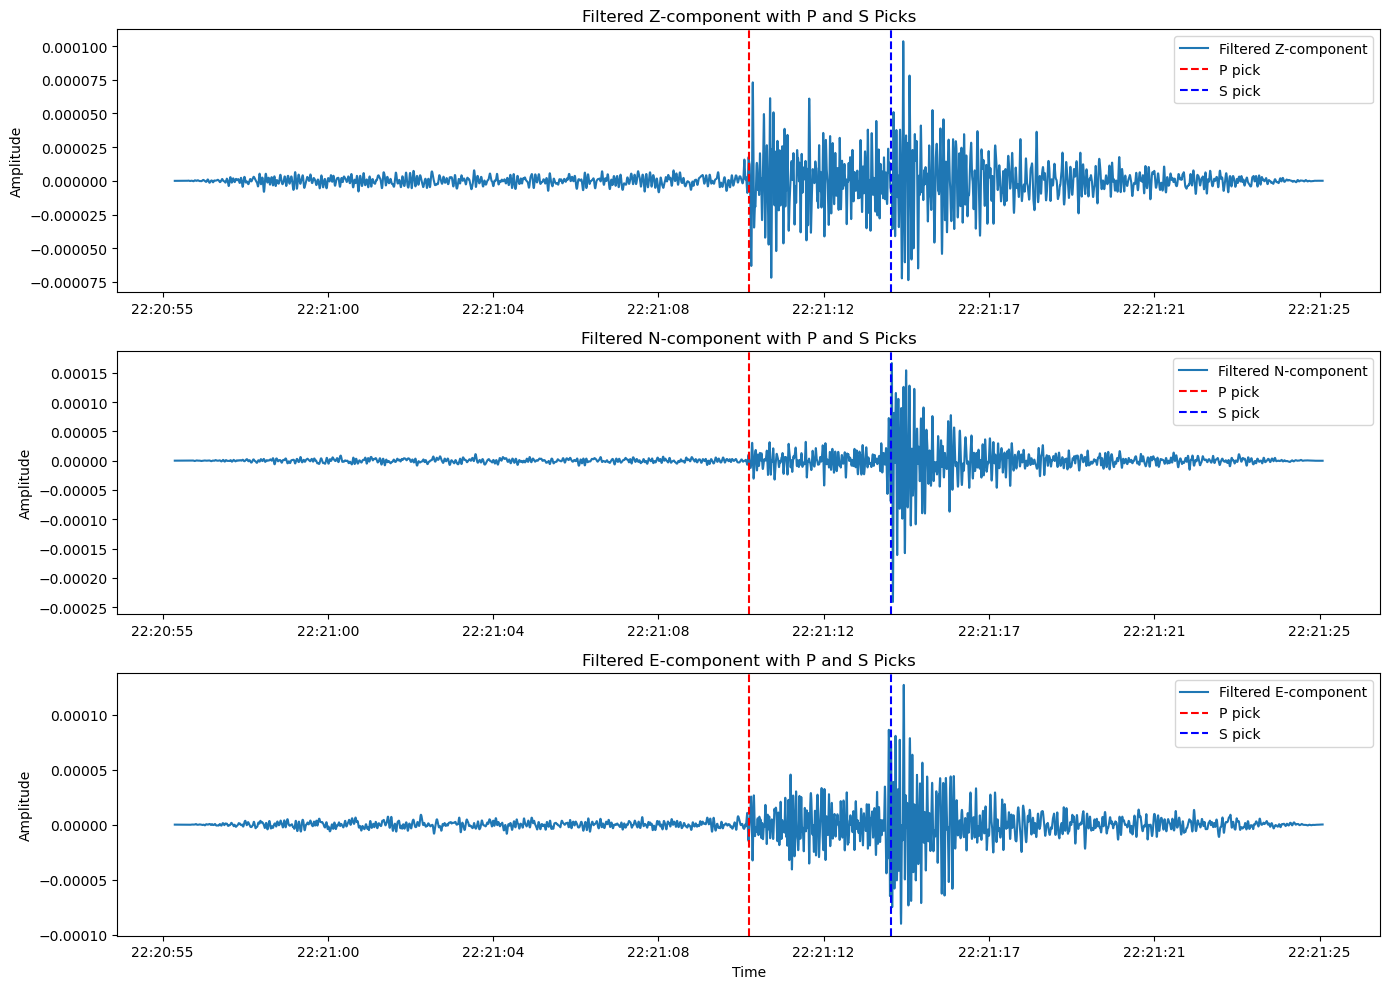

In [4]:
# 2. 設定檔案路徑
RAW_DATA_PATH = "/home/lulu/data/inci30"   
CORRECTED_DATA_PATH = '../data/fiber_corrected.parquet'  
event_date = "20231001-2221"

picking = process_event(event_date, f"{RAW_DATA_PATH}/borehole", output_path=None)
start_time = picking['P_pick'] - 1
end_time = picking['S_pick'] + 2

In [5]:
dasf = f"{RAW_DATA_PATH}/fiber/{event_date}.mseed"
channels = np.arange(len(read(dasf)))

In [6]:
st = read(dasf, starttime=start_time, endtime=end_time)
st_corrected = st.copy()
for i in np.arange(len(st)):
    st_corrected[i].data = st[i].data * DAS_CNST

Plotting traces: 100%|██████████████████████████| 57/57 [00:00<00:00, 92.52it/s]


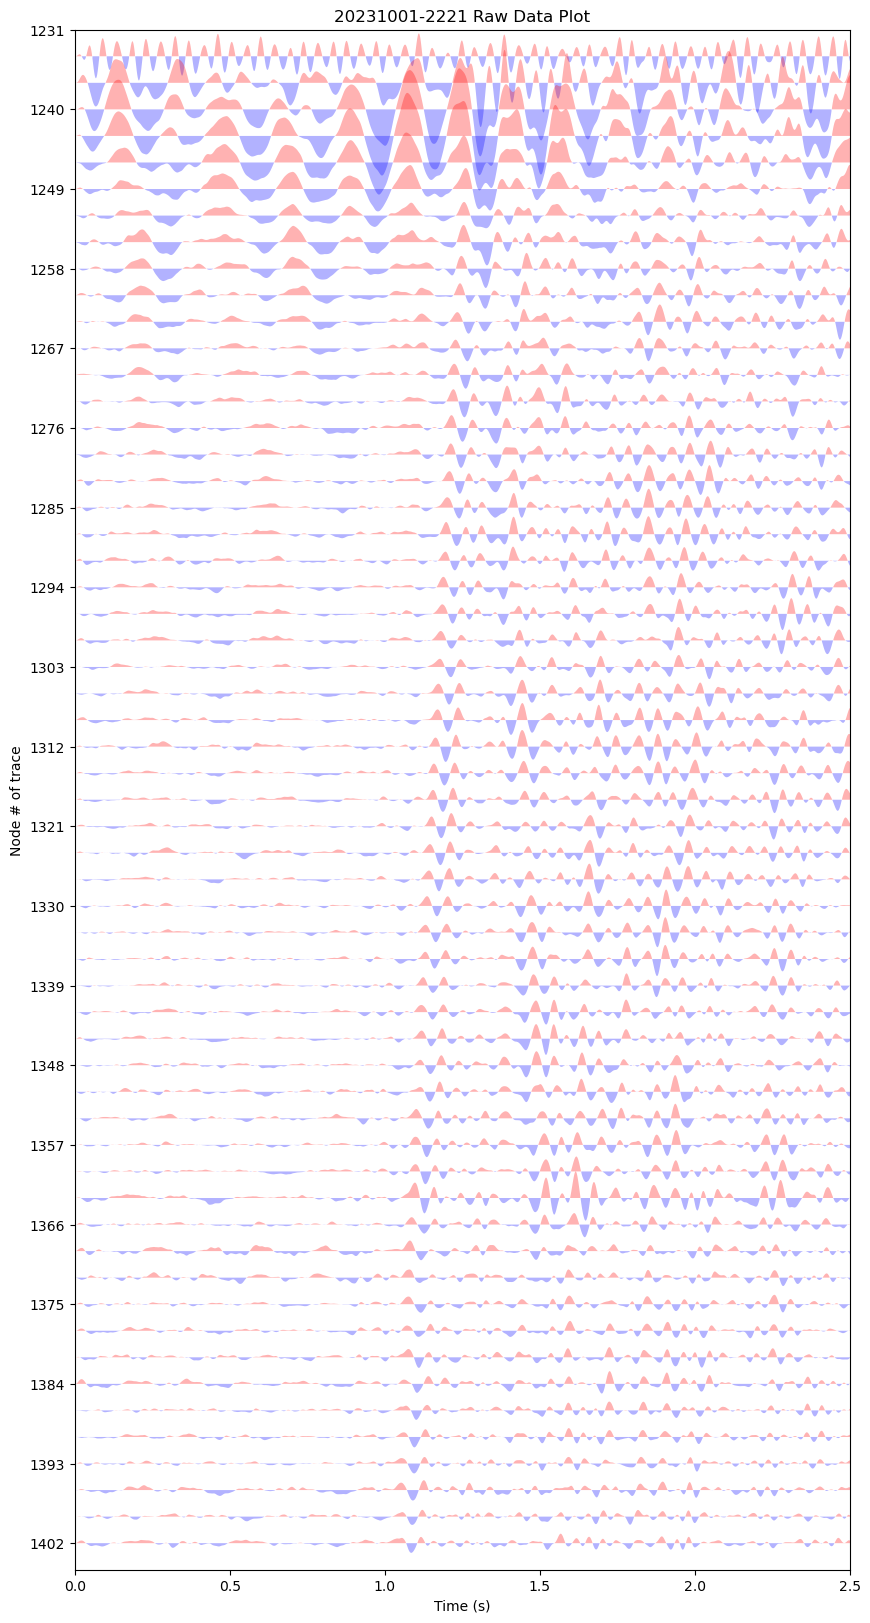

In [7]:
plot_filled_timeseries(
    st_corrected, startnode=1234, endnode=1404, intv=3,
    y_plot_scale=5e7, event_date=event_date, picking=picking, show_arrival=False,
    do_filter=True,
    filter_type='bandpass',
    filter_kwargs={'freqmin':1, 'freqmax':20}
)

In [8]:
A = load_das_profile(dasf, start_time, end_time, channels)
A_up_da, A, A_down_da = correct_surface_reflection(A)

100%|███████████████████████████████████| 1824/1824 [00:00<00:00, 106020.10it/s]


Filtering channels: 100%|█████████████████| 1824/1824 [00:00<00:00, 2871.79it/s]


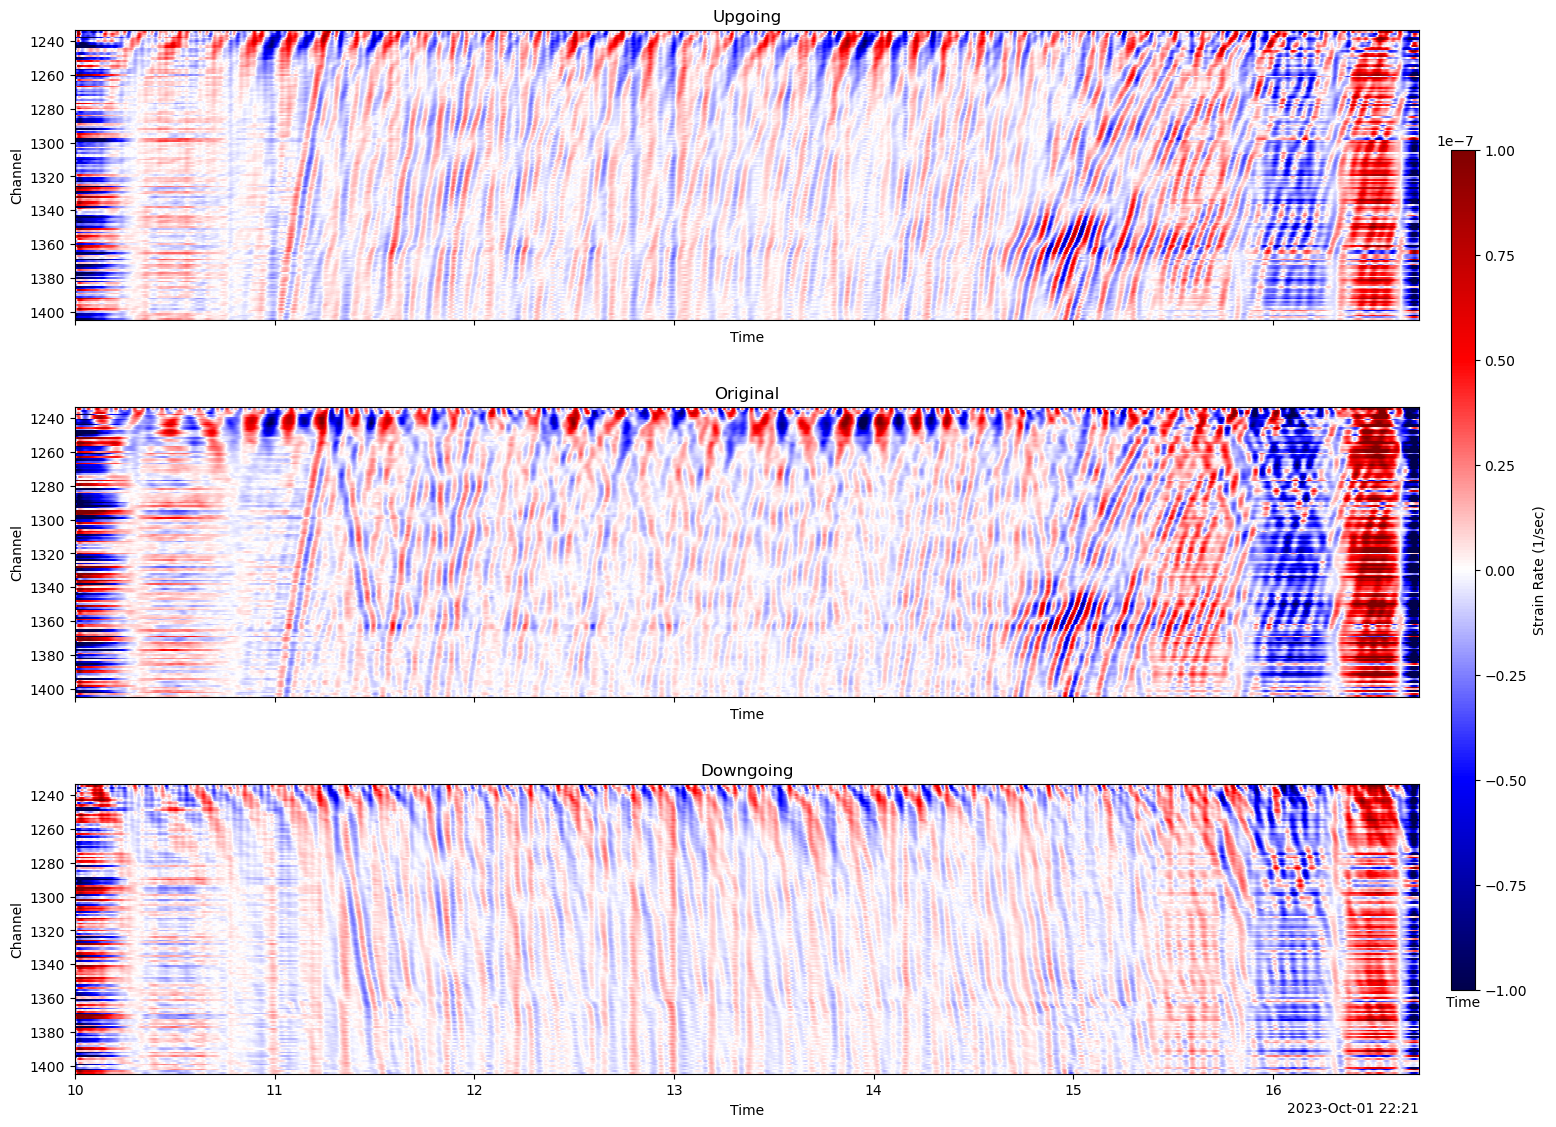

In [13]:
plot_up_down_original(A_up_da, A, A_down_da, do_filter=True)

Filtering channels: 100%|█████████████████| 1824/1824 [00:00<00:00, 2861.15it/s]


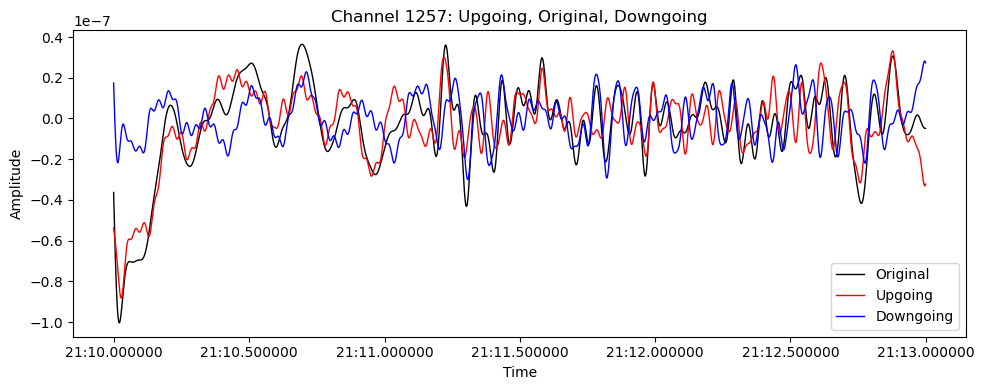

In [21]:
plot_channel_traces(A_up_da, A, A_down_da, channel_id=1257, seconds=3, do_filter=True)

In [22]:
A_up_da

<xarray.DataArray (channel: 1824, time: 6732)> Size: 98MB
array([[-6.21359782e-06,  1.31578531e-05,  6.20779782e-06, ...,
        -5.16670611e-06, -1.58891119e-05, -1.43479535e-06],
       [-1.44375704e-06,  6.15985613e-06, -4.85260037e-06, ...,
        -7.75263010e-06,  2.78331488e-06, -2.52004233e-07],
       [ 2.57045881e-06,  4.13657396e-06, -5.95048736e-06, ...,
        -2.55758880e-06, -4.92123355e-06, -3.01229901e-06],
       ...,
       [ 8.82970928e-07,  7.12614255e-07,  5.45649135e-07, ...,
         5.05011760e-07, -1.88754592e-06, -1.27348684e-06],
       [ 3.98828527e-06, -1.18355728e-05, -5.37553640e-06, ...,
         3.86696640e-07,  3.90870015e-06,  6.16678518e-06],
       [-1.85099323e-05, -1.24379684e-05,  1.22013823e-05, ...,
         3.72295152e-06, -5.49175191e-06, -9.09864852e-06]])
Coordinates:
  * time     (time) datetime64[ns] 54kB 2023-10-01T22:21:09.999001 ... 2023-1...
  * channel  (channel) int64 15kB 0 1 2 3 4 5 ... 1818 1819 1820 1821 1822 1823
    depth    (channel) float64 15kB 0.0 4.084 8.168 ... 7.441e+03 7.445e+03
Attributes:
    long_name:  Strain Rate
    units:      1/sec